# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

### Data
You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`)

The columns include:
 - browser
 - os
 - locale
 - user_id
 - location
 - sites
 - time
 - date

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

```
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



In [ ]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
# read the data from the csv file, and explore, what do we have
# WARNING: change the path to test on your machine

dataset = pd.read_csv('task 1.csv')
verify = pd.read_csv('task_1_verify.csv')
dataset.head()

,index,browser,os,locale,user_id,location,sites,time,date
0,8909,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28
1,17679,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26
2,11803,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13
3,356,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19
4,10948,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13


In [ ]:
# index doesn't give any usefull information, and date and time are also hardly connected with the current person we inspect, so we drop these features
dataset = dataset.drop(['index', 'date', 'time'], axis=1)
verify = verify.drop(['date', 'time'], axis=1)

# check if we did everything right
dataset.head()

,browser,os,locale,user_id,location,sites
0,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1..."
1,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le..."
2,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10..."
3,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s..."
4,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s..."


In [ ]:
# as the user_id is identifying the Wlado, then it is our label
# interpret in the way: 1 is Waldo, 0 is not the Waldo
y = dataset['user_id'].apply(lambda x: 1 if x == 0 else 0)

# check if we did everything right
y.info

<bound method Series.info of 0        0
1        0
2        0
3        0
4        0
        ..
20396    0
20397    0
20398    0
20399    0
20400    0
Name: user_id, Length: 20401, dtype: int64>

In [ ]:
# drop the 'user_id' column
dataset = dataset.drop('user_id', axis=1)

# check if we did everything right
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20401 entries, 0 to 20400
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   browser   20401 non-null  object
 1   os        20401 non-null  object
 2   locale    20401 non-null  object
 3   location  20401 non-null  object
 4   sites     20401 non-null  object
dtypes: object(5)
memory usage: 797.0+ KB


In [ ]:
# explore the values of the column 'browser'
dataset.browser.value_counts()

# we have 4 unique browsers without mistakes, and we need only to categorically encode them; we will do it later

Chrome               8413
Firefox              6196
Safari               3824
Internet Explorer    1968
Name: browser, dtype: int64

In [ ]:
# explore the values of the column 'os'
dataset.os.value_counts()

# we have 6 unique browsers without mistakes, and we need only to categorically encode them; we will do it later

Windows 10    8345
MacOS         3928
Windows 8     3173
Ubuntu        2076
Windows 7     1742
Debian        1137
Name: os, dtype: int64

In [ ]:
# explore the values of the column 'locale'
dataset.locale.value_counts()

# we have only one mistake: ru_RU and ru-RU are different locales, but they shoul represent only one locale - ru-RU

ro-RO    1670
bg-BG    1421
en-SG    1403
en-US    1209
nl-NL    1128
en-NZ    1107
xh-ZA    1106
en-CA    1021
ru_RU     985
pt-PT     939
uk-UA     897
pl-PL     709
fr-FR     709
vi-VN     701
ja-JP     625
en-AU     576
zh-CN     534
es-MX     520
it-IT     507
de-DE     504
wo-SN     501
en-GB     494
ru-RU     404
pt-BR     395
ur-PK     336
Name: locale, dtype: int64

In [ ]:
# define the substitution
cleanup_nums = {"locale": { "ru_RU": "ru-RU" }}

# fix mistake in both datasets
dataset.replace(cleanup_nums, inplace=True)
verify.replace(cleanup_nums, inplace=True)

In [ ]:
# explore the values of the column 'location'
dataset.location.value_counts()

# we have unique locations without mistakes, and we will encode them later

France/Paris             1625
New Zealand/Auckland     1508
Singapore/Singapore      1279
Germany/Berlin           1247
USA/Chicago              1096
Canada/Toronto           1095
Australia/Sydney         1064
Japan/Tokyo              1063
Canada/Vancouver         1050
UK/London                 935
USA/San Francisco         906
Malaysia/Kuala Lumpur     851
USA/Miami                 837
Spain/Madrid              836
Russia/Moscow             835
Italy/Rome                834
India/Delhi               773
Netherlands/Amsterdam     744
China/Shanghai            667
USA/New York              604
Brazil/Rio de Janeiro     552
Name: location, dtype: int64

In [ ]:
# explore the values of the column 'sites'
dataset.sites.value_counts()

# we have a lot of sites, so we need to shrink this number somehow

[{'site': 'annotathon.org', 'length': 113}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}]                                                                                                                       2
[{'site': 'annotathon.org', 'length': 162}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}, {'site': 'annotathon.org', 'length': 30}]                                                                                                                                                                 2
[{'site': 'annotathon.org', 'length': 170}, {'site': 'annotathon.org', 'length': 30}

In [ ]:
# we will choose only top 100 sites that were visited mostly
# firstly, extract the column 'sites' from both datasets
objects = dataset['sites'].apply(ast.literal_eval)
objectsV = verify['sites'].apply(ast.literal_eval)

# each row contains the list of dictionaries, let's put all dictionaries to one list
list_of_dicts = []
for row in objects:
  for d in row:
    list_of_dicts.append(d)

# now check all dicts and count the number of occurrences of each site
sites = {}
for d in list_of_dicts:
  site = d['site']
  if site not in sites:
    sites[site] = 1
  else:
    sites[site] = sites[site] + 1

# sort the tuples (site, occurrence) by the value, and pick 100 that occurred mostly
top_sites_tuples = sorted(sites.items(), key=lambda x:x[1])[-100:]

# create a list of top sites for easy usage in teh future
top_sites = []
for tup in top_sites_tuples:
  top_sites.append(tup[0])

# check if we did everything right
top_sites

['static.pubmed.gov',
 'ba.commentcamarche.net',
 'www.univ-bpclermont.fr',
 'go.trouter.io',
 'ssl.bing.com',
 'ent.univ-bpclermont.fr',
 'deliv.leboncoin.fr',
 'www.arb-silva.de',
 'pixel.alephd.com',
 'docs.oracle.com',
 'login.yahoo.com',
 'ts4.mm.bing.net',
 'ts2.mm.bing.net',
 'www.dailymotion.com',
 'docs.codehaus.org',
 'ts3.mm.bing.net',
 'windowslive.tt.omtrdc.net',
 '0.drive.google.com',
 'static.ccm2.net',
 'ocsp.tcs.terena.org',
 'syndication.twitter.com',
 'gg.google.com',
 'ocsp.usertrust.com',
 'www.linkedin.com',
 'ocsp.thawte.com',
 'office.microsoft.com',
 'talkgadget.google.com',
 'ocsp.verisign.com',
 'webmail.laposte.net',
 'slack.com',
 'youtube.com',
 'apr.lijit.com',
 'toptal.com',
 'gtssl-ocsp.geotrust.com',
 'chatenabled.mail.google.com',
 'lenta.ru',
 'armmf.adobe.com',
 'go.microsoft.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'maps.googleapis.com',
 'translate.google.com',
 'maps.google.fr',
 'javadl-esd-secure.oracle.com',
 'www.ebi.ac.uk',
 'vk.com',

In [ ]:
# now we will add new columns (for each of the top site) to our dataframes
for site in top_sites:
  dataset[site] = np.zeros(dataset.shape[0])
  verify[site] = np.zeros(verify.shape[0])

# as each row in the initial data contained different number of sites, we will iterate on the original data, check if the current site is the top site, and if it is, add the 'length' value to the appropriate column
row_number = 0
for row in objects:
  for site in row:
    if site['site'] in top_sites:
      dataset[site['site']][row_number] += site['length']
  row_number += 1

# repeat the procedure for the verify dataframe
row_number = 0
for row in objectsV:
  for site in row:
    if site['site'] in top_sites:
      verify[site['site']][row_number] += site['length']
  row_number += 1

# check if we did everything right
dataset.head()

<ipython-input-15-2ae1bfd8e6d6>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[site] = np.zeros(dataset.shape[0])
<ipython-input-15-2ae1bfd8e6d6>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  verify[site] = np.zeros(verify.shape[0])
<ipython-input-15-2ae1bfd8e6d6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[site['site'

,browser,os,locale,location,sites,static.pubmed.gov,ba.commentcamarche.net,www.univ-bpclermont.fr,go.trouter.io,ssl.bing.com,...,clients1.google.com,www.ncbi.nlm.nih.gov,mail.google.com,www.bing.com,blast.ncbi.nlm.nih.gov,www.facebook.com,apis.google.com,annotathon.org,www.google.com,www.google.fr
0,Firefox,Windows 10,zh-CN,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Internet Explorer,Windows 8,ro-RO,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",0.0,0.0,0.0,0.0,0.0,...,134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,Internet Explorer,MacOS,ur-PK,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",0.0,0.0,0.0,0.0,0.0,...,0.0,294.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
3,Internet Explorer,Ubuntu,pl-PL,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,92.0,0.0,0.0,0.0
4,Internet Explorer,Windows 8,bg-BG,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


In [ ]:
# check if we compute the 'length' right: we should see many different values
dataset['www.google.fr'].value_counts()

0.0      15963
1.0        240
2.0        146
3.0        107
4.0         65
         ...  
450.0        1
915.0        1
432.0        1
419.0        1
859.0        1
Name: www.google.fr, Length: 555, dtype: int64

In [ ]:
# we can drop column 'sites' now
dataset = dataset.drop('sites', axis=1)
verify = verify.drop('sites', axis=1)

# check if we did everything right
dataset.head()

,browser,os,locale,location,static.pubmed.gov,ba.commentcamarche.net,www.univ-bpclermont.fr,go.trouter.io,ssl.bing.com,ent.univ-bpclermont.fr,...,clients1.google.com,www.ncbi.nlm.nih.gov,mail.google.com,www.bing.com,blast.ncbi.nlm.nih.gov,www.facebook.com,apis.google.com,annotathon.org,www.google.com,www.google.fr
0,Firefox,Windows 10,zh-CN,China/Shanghai,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Internet Explorer,Windows 8,ro-RO,Germany/Berlin,0.0,0.0,0.0,0.0,0.0,0.0,...,134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,Internet Explorer,MacOS,ur-PK,Australia/Sydney,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,294.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
3,Internet Explorer,Ubuntu,pl-PL,Japan/Tokyo,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,92.0,0.0,0.0,0.0
4,Internet Explorer,Windows 8,bg-BG,Japan/Tokyo,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


In [ ]:
# columns 'browser', 'os', 'locale', and 'location' should be categoricaly encoded
encoder = OneHotEncoder()

# fit the encoder only on the training dataset
encoder.fit(dataset[['browser', 'os', 'locale', 'location']])

# transform columns
new_cols = encoder.transform(dataset[['browser', 'os', 'locale', 'location']]).toarray()
new_colsV = encoder.transform(verify[['browser', 'os', 'locale', 'location']]).toarray()

# change the type from array to dataframe
new_cols_df = pd.DataFrame(new_cols, columns=encoder.get_feature_names_out())
new_colsV_df = pd.DataFrame(new_colsV, columns=encoder.get_feature_names_out())

# make indexes the same
new_cols_df.index = dataset.index
new_colsV_df.index = verify.index

# concatenate original dataframe with the new columns
dataset = pd.concat([dataset, new_cols_df], axis=1)
verify = pd.concat([verify, new_colsV_df], axis=1)

# drop the original columns
dataset.drop(['browser', 'os', 'locale', 'location'], axis=1, inplace=True)
verify.drop(['browser', 'os', 'locale', 'location'], axis=1, inplace=True)

In [ ]:
# check if we did everything right
dataset

,static.pubmed.gov,ba.commentcamarche.net,www.univ-bpclermont.fr,go.trouter.io,ssl.bing.com,ent.univ-bpclermont.fr,deliv.leboncoin.fr,www.arb-silva.de,pixel.alephd.com,docs.oracle.com,...,location_Netherlands/Amsterdam,location_New Zealand/Auckland,location_Russia/Moscow,location_Singapore/Singapore,location_Spain/Madrid,location_UK/London,location_USA/Chicago,location_USA/Miami,location_USA/New York,location_USA/San Francisco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# check if we did everything right
verify

,static.pubmed.gov,ba.commentcamarche.net,www.univ-bpclermont.fr,go.trouter.io,ssl.bing.com,ent.univ-bpclermont.fr,deliv.leboncoin.fr,www.arb-silva.de,pixel.alephd.com,docs.oracle.com,...,location_Netherlands/Amsterdam,location_New Zealand/Auckland,location_Russia/Moscow,location_Singapore/Singapore,location_Spain/Madrid,location_UK/London,location_USA/Chicago,location_USA/Miami,location_USA/New York,location_USA/San Francisco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# split data on train/test
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=121, stratify=y)

In [ ]:
# define recall and precision functions for model efficiency control, because the dataset is unbalanced
def recall(y_true, y_pred):
    true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positive = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positive / (all_positive + K.epsilon())


def precision(y_true, y_pred):
    true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positive = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positive / (predicted_positive + K.epsilon())

In [ ]:
# function for creating model, because we will need to use this code many times in fine-tuning
def create_model(neurons, num_layers, dropout):
  model = Sequential([
    Dense(neurons, input_dim=X_train.shape[1], activation='relu'),
    Dropout(dropout),
  ])

  for i in range(num_layers):
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[recall, precision, 'accuracy'])

  return model

In [ ]:
# function for training model (also because we will use it many times)
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train,
              batch_size=256,
              epochs=30,
              verbose=1)
    return model

In [ ]:
# create some model without fine-tuning, train
model = create_model(15, 1, 0.0)
model = train_model(model, X_train, y_train)
y_pred = model.predict(X_test, verbose=0)

# interpret the predicted results with threshold = 0.5
for i in range(len(y_pred)):
  if y_pred[i] > 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

# print classification report to estimate the efficiency
print(classification_report(y_test, y_pred))

Epoch 1/30
64/64 [==============================] - 7s 7ms/step - loss: 1.6227 - recall: 0.9184 - precision: 0.1605 - accuracy: 0.8159
Epoch 2/30
64/64 [==============================] - 0s 6ms/step - loss: 0.1500 - recall: 0.9133 - precision: 0.5432 - accuracy: 0.9825
Epoch 3/30
64/64 [==============================] - 0s 6ms/step - loss: 0.0751 - recall: 0.9470 - precision: 0.8903 - accuracy: 0.9968
Epoch 4/30
64/64 [==============================] - 0s 6ms/step - loss: 0.0495 - recall: 0.9610 - precision: 0.9743 - accuracy: 0.9988
Epoch 5/30
64/64 [==============================] - 0s 5ms/step - loss: 0.0345 - recall: 0.9669 - precision: 0.9772 - accuracy: 0.9989
Epoch 6/30
64/64 [==============================] - 0s 6ms/step - loss: 0.0251 - recall: 0.9678 - precision: 0.9858 - accuracy: 0.9991
Epoch 7/30
64/64 [==============================] - 0s 5ms/step - loss: 0.0187 - recall: 0.9631 - precision: 0.9686 - accuracy: 0.9993
Epoch 8/30
64/64 [==============================] - 0s 

In [ ]:
# now we will fine-tune our model with tuning different parameters independently of each other
# set base values
best_neurons = 1
best_num_layers = 1
best_dropout = 0.0

# we will choose the best parameters by comparing the models using f1 score
best_f1 = 0

In [ ]:
# enumerate the number of neurons, create the model, train, test, and update the best_neurons parameter
for i in range(1, 21):
  model = create_model(i, best_num_layers, best_dropout)
  model = train_model(model, X_train, y_train)
  y_pred = model.predict(X_test, verbose=0)

  for k in range(len(y_pred)):
    if y_pred[k] > 0.5:
      y_pred[k] = 1
    else:
      y_pred[k] = 0

  f1 = metrics.f1_score(y_test, y_pred)
  if f1 > best_f1:
    best_f1 = f1
    best_neurons = i

# print the result
print(f'Best number of neurons = {best_neurons}')

Epoch 1/30
64/64 [==============================] - 2s 4ms/step - loss: 0.4641 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804
Epoch 2/30
64/64 [==============================] - 0s 4ms/step - loss: 0.2876 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804
Epoch 3/30
64/64 [==============================] - 0s 4ms/step - loss: 0.1717 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804
Epoch 4/30
64/64 [==============================] - 0s 4ms/step - loss: 0.1171 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804
Epoch 5/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0902 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804
Epoch 6/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0729 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804
Epoch 7/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0593 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.9804

In [ ]:
# try to create 2 layers instead of one
model = create_model(best_neurons, 2, best_dropout)
model = train_model(model, X_train, y_train)
y_pred = model.predict(X_test, verbose=0)
for k in range(len(y_pred)):
  if y_pred[k] > 0.5:
    y_pred[k] = 1
  else:
    y_pred[k] = 0

# remember the number of layers if it improved the efficiency
f1 = metrics.f1_score(y_test, y_pred)
if f1 > best_f1:
  best_f1 = f1
  best_num_layers = 2

# print the result
print(f'Best number of layers = {best_num_layers}')

Epoch 1/30
64/64 [==============================] - 2s 5ms/step - loss: 1.6316 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.6923
Epoch 2/30
64/64 [==============================] - 0s 4ms/step - loss: 0.3118 - recall: 0.0043 - precision: 0.0031 - accuracy: 0.9438
Epoch 3/30
64/64 [==============================] - 0s 4ms/step - loss: 0.1507 - recall: 0.0484 - precision: 0.0935 - accuracy: 0.9722
Epoch 4/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0950 - recall: 0.0640 - precision: 0.1719 - accuracy: 0.9782
Epoch 5/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0662 - recall: 0.1054 - precision: 0.3359 - accuracy: 0.9814
Epoch 6/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0490 - recall: 0.2552 - precision: 0.5828 - accuracy: 0.9852
Epoch 7/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0306 - recall: 0.7326 - precision: 0.9241 - accuracy: 0.9948
Epoch 8/30
64/64 [=============================

In [ ]:
# enumerate the sropout, create the model, train, test, and update the best_dropout parameter
for i in range(0, 10):
  model = create_model(best_neurons, best_num_layers, i/10)
  model = train_model(model, X_train, y_train)
  y_pred = model.predict(X_test, verbose=0)

  for k in range(len(y_pred)):
    if y_pred[k] > 0.5:
      y_pred[k] = 1
    else:
      y_pred[k] = 0

  f1 = metrics.f1_score(y_test, y_pred)
  if f1 > best_f1:
    best_f1 = f1
    best_dropout = i/10

# print the result
print(f'Best dropout = {best_dropout}')

Epoch 1/30
64/64 [==============================] - 2s 4ms/step - loss: 0.4981 - recall: 0.5732 - precision: 0.1355 - accuracy: 0.8880
Epoch 2/30
64/64 [==============================] - 0s 4ms/step - loss: 0.1264 - recall: 0.8010 - precision: 0.3921 - accuracy: 0.9703
Epoch 3/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0626 - recall: 0.8804 - precision: 0.5743 - accuracy: 0.9841
Epoch 4/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0322 - recall: 0.9155 - precision: 0.7477 - accuracy: 0.9922
Epoch 5/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0177 - recall: 0.9119 - precision: 0.8966 - accuracy: 0.9969
Epoch 6/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0121 - recall: 0.9210 - precision: 0.9210 - accuracy: 0.9976
Epoch 7/30
64/64 [==============================] - 0s 4ms/step - loss: 0.0086 - recall: 0.9573 - precision: 0.9593 - accuracy: 0.9983
Epoch 8/30
64/64 [==============================] - 0s 

In [ ]:
# create the model with the best parameters, train, test
model = create_model(best_neurons, best_num_layers, best_dropout)
model = train_model(model, X_train, y_train)
y_pred = model.predict(X_test, verbose=0)

for i in range(len(y_pred)):
  if y_pred[i] > 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

# print the result
print(classification_report(y_test, y_pred))

Epoch 1/30
64/64 [==============================] - 2s 6ms/step - loss: 10.9630 - recall: 1.0000 - precision: 0.0233 - accuracy: 0.1631
Epoch 2/30
64/64 [==============================] - 0s 6ms/step - loss: 3.8417 - recall: 0.9844 - precision: 0.0327 - accuracy: 0.4126
Epoch 3/30
64/64 [==============================] - 0s 6ms/step - loss: 1.6017 - recall: 0.9948 - precision: 0.0575 - accuracy: 0.6645
Epoch 4/30
64/64 [==============================] - 0s 6ms/step - loss: 0.7776 - recall: 0.9829 - precision: 0.1115 - accuracy: 0.8333
Epoch 5/30
64/64 [==============================] - 0s 6ms/step - loss: 0.4499 - recall: 0.9638 - precision: 0.2535 - accuracy: 0.9362
Epoch 6/30
64/64 [==============================] - 0s 6ms/step - loss: 0.2657 - recall: 0.9647 - precision: 0.5828 - accuracy: 0.9852
Epoch 7/30
64/64 [==============================] - 0s 6ms/step - loss: 0.1609 - recall: 0.9637 - precision: 0.8877 - accuracy: 0.9971
Epoch 8/30
64/64 [==============================] - 0s

In [ ]:
# predict on verify
y_verify_pred = model.predict(verify, verbose=0)

# print the answer
for i in range(len(y_verify_pred)):
  if y_verify_pred[i] > 0.5:
    print(str(i) + ": 1")
  else:
    print(str(i) + ": 0")


0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 1
32: 1
33: 1
34: 1
35: 1


The "browser," "os," "locale," "sites," and "location" features are sufficient for training the model. However, the "time" and "date" features are not very informative due to the large number of unique classes they contain, which could result in the model being overfitted.

I used the OneHotEncoder for both the training and testing sets, one-hot encoding all categorical characteristics, such as "browser," "os," "locale," and "location." I fixed the error in the "locale" values and added new columns for the top 100 websites.

I've used for loop to choose the best number of neurons, number of layers, and to choose the best dropout. But in my opinion the model before the fine-tuning was acceptable, and fine-tuning was not very necessary

Given that our dataset is unbalanced, I chose the f1 score as the metric for model optimization. I also added measures for recall, precision, and accuracy to the model. The outcomes are improved when all of these metrics are maximized.

# Task 2: Fingerprint Recognition
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

### Data
[Download link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

You will be working with the data in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

In [ ]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input

In [ ]:
# unzip the files
# WARNING: change the path to test on your machine
!unzip 'task 2.zip'
!unzip -q train.zip
!unzip -q test.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/Assignment/task 2.zip
 extracting: test.zip                
 extracting: train.zip               


In [ ]:
# function for preprocessing one image
def preprocess_image(img_path):
  img = cv2.imread(img_path)

  # change the extension if it is not .bmp
  if not img_path.endswith('.bmp'):
      cv2.imwrite(img_path + '.bmp', img)
      img_path += '.bmp'

  # extract the label
  label = int(os.path.basename(img_path).split('_')[1].split('.')[0])

  # resize the image for the future model
  img = cv2.resize(img, (277, 277), interpolation = cv2.INTER_NEAREST)

  # convert to grayscale to reduce unnecessary information
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  return (gray_img[:,:,np.newaxis], label)

In [ ]:
# get the training data from the path
dataset = []
for f in os.listdir('train/'):
  path = os.path.join('train/', f)
  img, label = preprocess_image(path)
  dataset.append((img, label))

# split the training data on the training and validation data
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, stratify=[data[1] for data in dataset])

# parse the data
X_train = np.array([data[0] for data in train_dataset])
y_train = to_categorical(np.array([data[1] for data in train_dataset]), num_classes=10)
X_val = np.array([data[0] for data in val_dataset])
y_val = to_categorical(np.array([data[1] for data in val_dataset]), num_classes=10)

In [ ]:
# get the test data from the path
test = []
for f in os.listdir('content/test/'):
  path = os.path.join('content/test/', f)
  img, label = preprocess_image(path)
  test.append((img, label))

# parse the data
X_test = np.array([data[0] for data in test])
y_test = np.array([data[1] for data in test])

In [ ]:
# The paper:
# https://core.ac.uk/download/pdf/162665805.pdf (CaffeNet variant without grouping)

model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation="relu", input_shape=(277, 277, 1)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation="relu"),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu"),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation="relu"),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model.fit(
    X_train,
    y_train,
    epochs=75,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(train_dataset) // 128,
    validation_steps=len(val_dataset) // 128,
)

# IMPORTANT COMMENT
# you can see the output for 25 epochs
# I cannot train more, because google colab ends the session due to exceeding the limit on memory

Epoch 1/25
121/121 [==============================] - 33s 168ms/step - loss: 2.9653 - accuracy: 0.1661 - val_loss: 2.0564 - val_accuracy: 0.2403
Epoch 2/25
121/121 [==============================] - 14s 117ms/step - loss: 1.9417 - accuracy: 0.2757 - val_loss: 1.7933 - val_accuracy: 0.3366
Epoch 3/25
121/121 [==============================] - 15s 123ms/step - loss: 1.7818 - accuracy: 0.3414 - val_loss: 1.6132 - val_accuracy: 0.4005
Epoch 4/25
121/121 [==============================] - 14s 120ms/step - loss: 1.5940 - accuracy: 0.4093 - val_loss: 1.4835 - val_accuracy: 0.4535
Epoch 5/25
121/121 [==============================] - 14s 118ms/step - loss: 1.4365 - accuracy: 0.4724 - val_loss: 1.3882 - val_accuracy: 0.4831
Epoch 6/25
121/121 [==============================] - 14s 117ms/step - loss: 1.3040 - accuracy: 0.5178 - val_loss: 1.2222 - val_accuracy: 0.5475
Epoch 7/25
121/121 [==============================] - 14s 115ms/step - loss: 1.1937 - accuracy: 0.5620 - val_loss: 1.1714 - val_ac

In [ ]:
# predict on the test data
y_pred = model.predict(X_test)

# get the class with the highest probability
y_pred = np.argmax(y_pred, axis=1)

# print classification report
print(classification_report(y_test, y_pred))

# output for 25 epochs

446/446 [==============================] - 8s 15ms/step
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1617
           1       0.50      0.62      0.55      1415
           2       0.49      0.57      0.53      1479
           3       0.56      0.46      0.51      1498
           4       0.53      0.62      0.57      1372
           5       0.92      0.82      0.87      1467
           6       0.70      0.69      0.70      1305
           7       0.54      0.66      0.60      1369
           8       0.65      0.47      0.55      1406
           9       0.65      0.51      0.57      1344

    accuracy                           0.62     14272
   macro avg       0.63      0.62      0.62     14272
weighted avg       0.63      0.62      0.62     14272



In [ ]:
# for fine-tuning I manually changed the architecture to obtain better result
model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation="relu", input_shape=(277, 277, 1)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation="relu"),
    # add new layer
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation="relu"),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu"),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation="relu"),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(
    X_train,
    y_train,
    epochs=75,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(train_dataset) // 128,
    validation_steps=len(val_dataset) // 128,
)

# predict on the test data and get class with the highest probability
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# print the classification report
print(classification_report(y_test, y_pred))

# IMPORTANT COMMENT
# here google colab ended the session because of the limit, please, run it on your machine, or
# maybe you have more resourses on colab

Epoch 1/25
121/121 [==============================] - 57s 287ms/step - loss: 3.2050 - accuracy: 0.1695 - val_loss: 1.9296 - val_accuracy: 0.2722
Epoch 2/25
121/121 [==============================] - 24s 201ms/step - loss: 1.9430 - accuracy: 0.2695 - val_loss: 1.8162 - val_accuracy: 0.3173
Epoch 3/25
121/121 [==============================] - 25s 204ms/step - loss: 1.7765 - accuracy: 0.3312 - val_loss: 1.7583 - val_accuracy: 0.3351
Epoch 4/25
121/121 [==============================] - 24s 197ms/step - loss: 1.6577 - accuracy: 0.3761 - val_loss: 1.5845 - val_accuracy: 0.3922
Epoch 5/25
121/121 [==============================] - 25s 205ms/step - loss: 1.4976 - accuracy: 0.4428 - val_loss: 1.5505 - val_accuracy: 0.4272
Epoch 6/25
121/121 [==============================] - 25s 205ms/step - loss: 1.4019 - accuracy: 0.4854 - val_loss: 1.4156 - val_accuracy: 0.4919
Epoch 7/25
121/121 [==============================] - 25s 204ms/step - loss: 1.2707 - accuracy: 0.5316 - val_loss: 1.2667 - val_ac

In [ ]:
# initialize ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.03,
    height_shift_range=0.03,
    horizontal_flip=False,
    vertical_flip=False
)

train_generator = data_generator.flow(X_train, y_train, batch_size=256)

# train the model
model.fit(train_generator,
          epochs=75,
          validation_data=(X_val, y_val),
          steps_per_epoch=len(train_dataset) // 128,
          validation_steps=len(val_dataset) // 128,
          )

# predict on the test data and get class with the highest probability
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# print the classification report
print(classification_report(y_test, y_pred))

# Task 3: Credit approval

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
# read the dataset from the csv
# WARNING: change the path to test on your machine
dataset = pd.read_csv('loan_data.csv')

# check if we did everything right
dataset.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [ ]:
# as the 'credit.policy' is our label, extract it from the dataset and name as 'y'
y = dataset['credit.policy']
# drop this column
dataset = dataset.drop('credit.policy', axis=1)

# check if we did everything right
print(y)
dataset

0       1
1       1
2       1
3       1
4       1
       ..
9573    0
9574    0
9575    0
9576    0
9577    0
Name: credit.policy, Length: 9578, dtype: int64


,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [ ]:
# check the values of the column 'purpose'
dataset.purpose.value_counts()

# we have small amount of uniwue values, and we will encode them categorically

debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64

In [ ]:
# use OneHotEncoder
encoder = OneHotEncoder()

# fir the encoder
encoder.fit(dataset[['purpose']])

# transform the column
new_cols = encoder.transform(dataset[['purpose']]).toarray()

# convert the array to dataframe
new_cols_df = pd.DataFrame(new_cols, columns=encoder.get_feature_names_out())

# make indexes the same
new_cols_df.index = dataset.index

# concatenate the original dataset with new columns
dataset = pd.concat([dataset, new_cols_df], axis=1)

# drop initial columns
dataset.drop('purpose', axis=1, inplace=True)

# check if we did everything right
dataset

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9574,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9575,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9576,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# split the data on train/test
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=121, stratify = y)

In [ ]:
# initialize the simple decision tree without fine-tuning, train
dt = DecisionTreeClassifier(random_state=121)
dt.fit(X_train, y_train)

# predict on the test data and print classification report
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       374
           1       0.99      0.99      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.98      0.98      0.98      1916
weighted avg       0.99      0.99      0.99      1916



In [ ]:
# initialize the simple random forest without fine-tuning, train
rf = RandomForestClassifier(random_state=121)
rf.fit(X_train, y_train)

# predict on the test data and print classification report
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       374
           1       0.99      1.00      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.99      0.97      0.98      1916
weighted avg       0.99      0.99      0.99      1916



In [ ]:
# fine-tune the decision tree with the following parameters using GridSearch
param_grid = {'max_depth': range(1, 11, 2), 'min_samples_split': range(2, 11, 2), 'min_samples_leaf': range(1, 6)}
dt_cv = GridSearchCV(dt, param_grid, cv=6)
dt_cv.fit(X_train, y_train)

# predict on the test data and print classification report
y_pred_dt = dt_cv.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       374
           1       0.99      0.99      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.98      0.98      0.98      1916
weighted avg       0.99      0.99      0.99      1916



In [ ]:
# fine-tune the random forest with the following parameters using GridSearch
param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': range(1, 11, 2), 'min_samples_split': range(2, 11, 2)}
rf_cv = GridSearchCV(rf, param_grid, cv=6)
rf_cv.fit(X_train, y_train)

# predict on the test data and print classification report
y_pred_rf = rf_cv.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       374
           1       0.98      1.00      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.99      0.96      0.98      1916
weighted avg       0.99      0.99      0.99      1916



In [ ]:
# compare the accuracy of both models
acc_dt = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy:', acc_dt)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy:', acc_rf)

# both models fit well to our datam but decision tree a little better

Decision Tree Accuracy: 0.9895615866388309
Random Forest Accuracy: 0.9853862212943633


[Text(0.7660845588235294, 0.95, 'dti <= 24.995\ngini = 0.315\nsamples = 4826\nvalue = [1503, 6159]\nclass = 1'),
 Text(0.5909926470588235, 0.85, 'purpose_educational <= 0.5\ngini = 0.3\nsamples = 4750\nvalue = [1387, 6155]\nclass = 1'),
 Text(0.2849264705882353, 0.75, 'inq.last.6mths <= 3.5\ngini = 0.295\nsamples = 4573\nvalue = [1304, 5940]\nclass = 1'),
 Text(0.0974264705882353, 0.65, 'fico <= 659.5\ngini = 0.142\nsamples = 4010\nvalue = [485, 5841]\nclass = 1'),
 Text(0.04411764705882353, 0.55, 'inq.last.6mths <= 1.5\ngini = 0.017\nsamples = 150\nvalue = [236, 2]\nclass = 0'),
 Text(0.029411764705882353, 0.45, 'fico <= 634.5\ngini = 0.027\nsamples = 93\nvalue = [143, 2]\nclass = 0'),
 Text(0.014705882352941176, 0.35, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]\nclass = 1'),
 Text(0.04411764705882353, 0.35, 'gini = 0.0\nsamples = 90\nvalue = [142, 0]\nclass = 0'),
 Text(0.058823529411764705, 0.45, 'gini = 0.0\nsamples = 57\nvalue = [93, 0]\nclass = 0'),
 Text(0.15073529411764705, 0.55

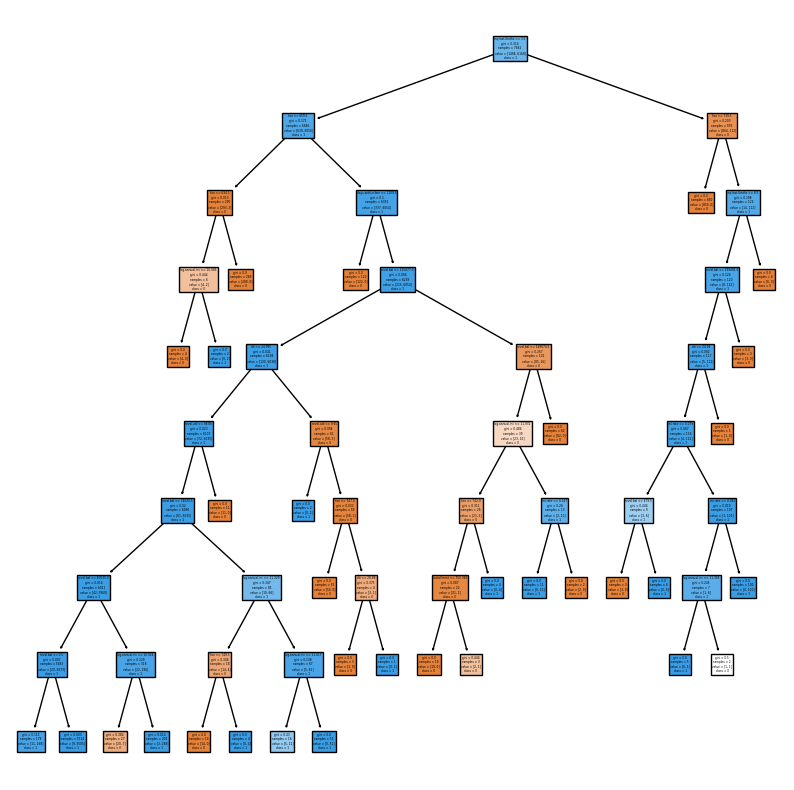

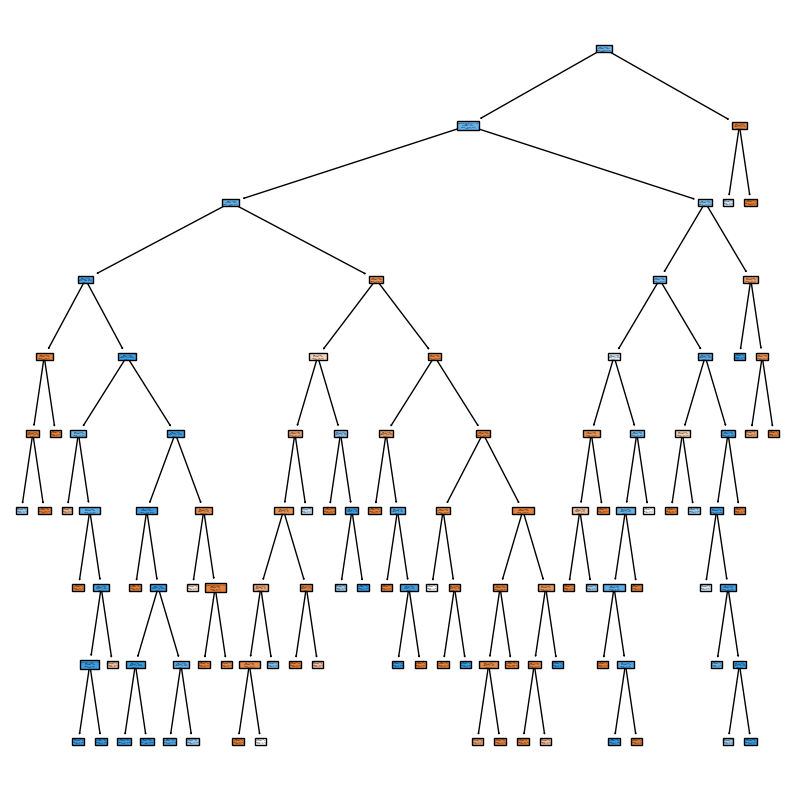

In [ ]:
# visualize the models
plt.figure(figsize=(10,10))
plot_tree(dt_cv.best_estimator_, feature_names=X_train.columns, class_names=['0', '1'], filled=True)
plt.figure(figsize=(10,10))
plot_tree(rf_cv.best_estimator_.estimators_[0], feature_names=X_train.columns, class_names=['0', '1'], filled=True)

For the test set, the decision tree and random forest models both displayed equal performance, scoring similarly accurate. The decision tree model might be better appropriate for smaller datasets when interpretability is critical, even though the random forest model has advantages including the ability to handle larger datasets and reduce overfitting.

Following adjustments, the decision tree's maximum depth was 11, compared to the random forest's maximum depth for each tree, which was 10. One of several hyperparameters that can be adjusted is the ideal max depth, which varies depending on the particular dataset and situation at hand.

A machine learning technique called ensemble learning mixes many models to increase prediction accuracy and decrease overfitting. Its benefits include greater generalization, increased accuracy, and resistance to noise and outliers. It can, however, be computationally expensive, necessitate substantial data preprocessing, and be challenging to understand and interpret.

By integrating several weak models, boosting methods take a sequential approach to creating a strong model. Each instance in the data set is given a weight by AdaBoost, which then trains the model in sequential fashion with modified weights. Gradient Boosting creates the model step-by-step, fitting a weak learner to the remaining errors from the previous iteration.

By training them on various subsets of the data, bagging techniques produce several models. A sort of bagging method called Random Forest combines the forecasts of several decision trees applied to various random subsets of data. Bootstrap Aggregation (Bagging) works by resampling the data with replacement to create numerous subsets, then training the model on each subset. The category of bagging includes RF.